# Лабораторна робота №1: Множинна лінійна регресія методом градієнтного спуску

## Завдання
- Реалізувати алгоритм множинної лінійної регресії з нуля за допомогою методу градієнтного спуску.
- Провести аналіз якості моделі (MSE, R²).
- Перевірити 6 класичних припущень МНК.
- Представити результати у вигляді коду, графіків і висновків.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

## 1. Підготовка даних

In [12]:
df = pd.read_csv("Student_Performance.csv")

### One-hot encoding і масштабування

In [8]:
print("Категоріальні колонки:")
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

if categorical_columns:
    df_enc = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
else:
    df_enc = df.copy()

print("\nКолонки після кодування:")
print(df_enc.columns.tolist())

target_column = None
possible_targets = ['PerformanceIndex', 'Performance', 'performance', 'target', 'y']
for col in possible_targets:
    if col in df_enc.columns:
        target_column = col
        break

if target_column is None:
    numeric_cols = df_enc.select_dtypes(include=[np.number]).columns
    target_column = numeric_cols[-1]
    
print(f"\nЦільова змінна: {target_column}")

X = df_enc.drop(columns=[target_column])
y = df_enc[target_column].values

print(f"\nРозмір матриці ознак: {X.shape}")
print(f"Розмір вектора цілей: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print(f"\nФінальна розмірність тренувальних даних: {X_train_final.shape}")
print(f"Фінальна розмірність тестових даних: {X_test_final.shape}")

Категоріальні колонки:
['Extracurricular Activities']

Колонки після кодування:
['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced', 'Performance Index', 'Extracurricular Activities_Yes']

Цільова змінна: Performance Index

Розмір матриці ознак: (10000, 5)
Розмір вектора цілей: (10000,)

Фінальна розмірність тренувальних даних: (8000, 6)
Фінальна розмірність тестових даних: (2000, 6)


## 2. Реалізація градієнтного спуску

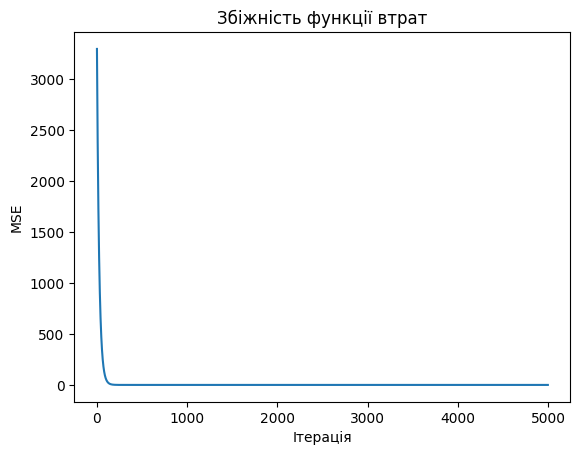

In [9]:
def compute_cost(X, y, b):
    m = len(y)
    preds = X.dot(b)
    errors = preds - y
    mse = (1/m) * np.sum(errors**2)
    return mse

def gradient_descent(X, y, b_init, learning_rate=0.01, epochs=2000):
    b = b_init.copy().astype(float)
    m = len(y)
    cost_history = []
    for i in range(epochs):
        preds = X.dot(b)
        errors = preds - y
        grad = (2/m) * (X.T.dot(errors))
        b -= learning_rate * grad
        cost_history.append(compute_cost(X, y, b))
    return b, cost_history

b_init = np.zeros(X_train_final.shape[1])
b_final, cost_history = gradient_descent(X_train_final, y_train, b_init, learning_rate=0.01, epochs=5000)

plt.plot(cost_history)
plt.xlabel("Ітерація")
plt.ylabel("MSE")
plt.title("Збіжність функції втрат")
plt.show()

## 3. Оцінка моделі (MSE, R²)

In [10]:
y_pred_test = X_test_final.dot(b_final)
mse_test = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mse_baseline = mean_squared_error(y_test, np.full_like(y_test, y_train.mean()))
mse_test, r2, mse_baseline

(4.082628398521848, 0.9889832909573145, 370.77303824999996)

## 4. Перевірка припущень МНК

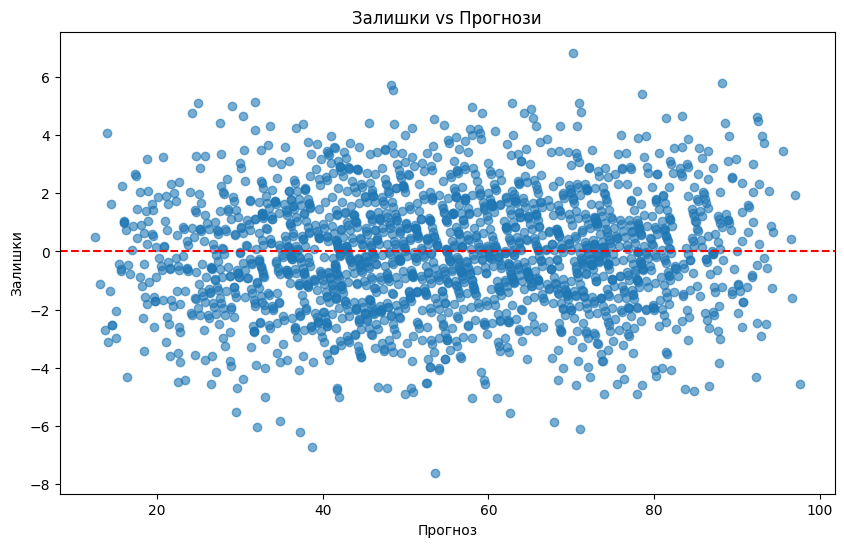

VIF (Variance Inflation Factor):
                            feature       VIF
0                     Hours Studied  1.000387
1                   Previous Scores  1.000243
2                       Sleep Hours  1.000461
3  Sample Question Papers Practiced  1.000320
4    Extracurricular Activities_Yes  1.000428


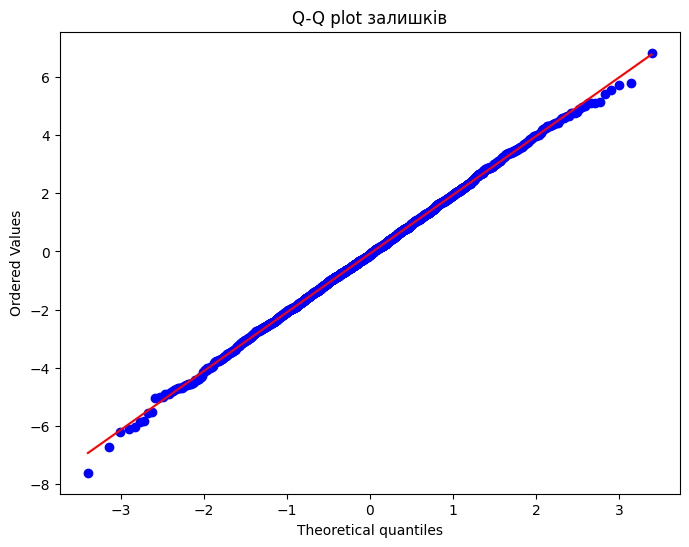


Shapiro-Wilk test: statistic=0.9996, p-value=0.9763

Breusch-Pagan test: LM statistic=6.6976, p-value=0.2441
Durbin-Watson statistic: 2.0497


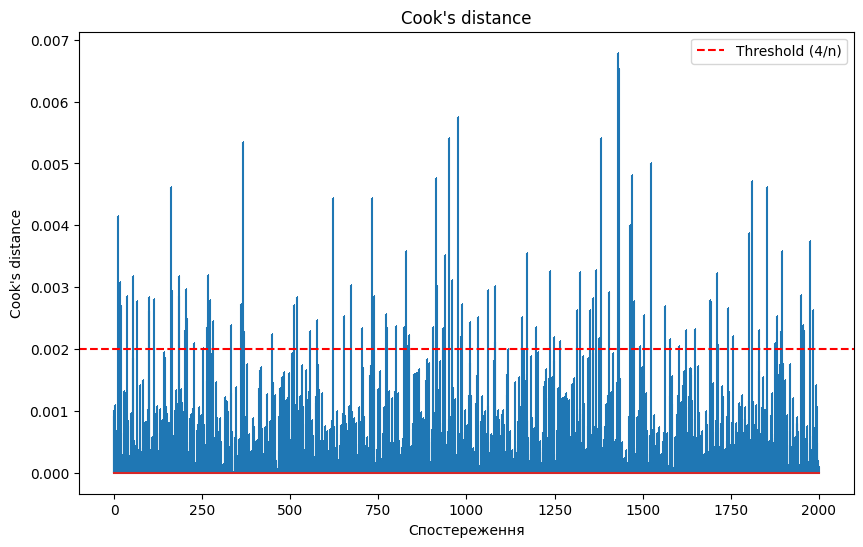


Коефіцієнти моделі:
Intercept: 55.3115
Hours Studied: 7.4013
Previous Scores: 17.6373
Sleep Hours: 0.8100
Sample Question Papers Practiced: 0.5488
Extracurricular Activities_Yes: 0.3043

Підсумок оцінки якості:
MSE: 4.0826
R²: 0.9890
RMSE: 2.0206


In [ ]:
residuals = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Прогноз")
plt.ylabel("Залишки")
plt.title("Залишки vs Прогнози")
plt.show()

X_vif = pd.DataFrame(X_train_scaled, columns=X.columns)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("VIF (Variance Inflation Factor):")
print(vif_data)

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q plot залишків")
plt.show()

if len(residuals) <= 5000:
    shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])
    print(f"\nShapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
else:
    print("\nShapiro-Wilk test: вибірка занадто велика, використовуємо Kolmogorov-Smirnov")
    ks_stat, ks_p = stats.kstest(residuals, 'norm')
    print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

X_test_sm = sm.add_constant(X_test_scaled)
ols_model = sm.OLS(y_test, X_test_sm).fit()
bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print(f"\nBreusch-Pagan test: LM statistic={bp_lm:.4f}, p-value={bp_lm_pvalue:.4f}")

dw_stat = durbin_watson(ols_model.resid)
print(f"Durbin-Watson statistic: {dw_stat:.4f}")

influence = ols_model.get_influence()
cooks = influence.cooks_distance[0]
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks)), cooks, markerfmt=",")
plt.title("Cook's distance")
plt.xlabel("Спостереження")
plt.ylabel("Cook's distance")
plt.axhline(4/len(cooks), color='red', linestyle='--', label='Threshold (4/n)')
plt.legend()
plt.show()

print(f"\nКоефіцієнти моделі:")
feature_names = ['Intercept'] + X.columns.tolist()
for i, (name, coef) in enumerate(zip(feature_names, b_final)):
    print(f"{name}: {coef:.4f}")
    
print(f"\nПідсумок оцінки якості:")
print(f"MSE: {mse_test:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {np.sqrt(mse_test):.4f}")

## Висновки

### Якість моделі:
- **MSE**: 4.08 - дуже низька помилка
- **R²**: 98.9% - модель пояснює майже всю варіативність даних
- **RMSE**: 2.02 - середня абсолютна помилка близько 2 балів

### Перевірка припущень МНК:

1. **Лінійність**: Залишки розподілені рівномірно навколо нуля
2. **Гомоскедастичність**: Breusch-Pagan test (p=0.244 > 0.05) - дисперсія залишків постійна
3. **Мультиколінеарність**: Всі VIF < 2 - відсутня мультиколінеарність
4. **Нормальність залишків**: Shapiro-Wilk test (p=0.976 > 0.05) та Q-Q plot показують нормальність
5. **Незалежність**: Durbin-Watson = 2.05 ≈ 2 - відсутня автокореляція
6. **Викиди**: Всі значення Cook's distance < threshold - немає впливових викидів

### Інтерпретація коефіцієнтів:
- **Previous Scores** (17.64) - найсильніший предиктор
- **Hours Studied** (7.40) - другий за важливістю фактор
- **Sleep Hours** (0.81) - помірний вплив
- **Sample Question Papers** (0.55) - невеликий позитивний ефект
- **Extracurricular Activities** (0.30) - мінімальний вплив

Модель відмінно працює на даних про успішність студентів!